In [61]:
# !rm -rf data/ecgs.zarr
# !./ingest_ecg_records.py

In [239]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from sklearn.preprocessing import normalize
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

# store = zarr.DirectoryStore("data/ecgs.zarr")
# root = zarr.group(store=store, overwrite=False)
# root = zarr.open("data/ecgs.zarr")

root = zarr.open_group("data/ecgs.zarr", mode="r")
root.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,0
No. groups,3
Groups,"beats, cleaned, raw"


In [136]:
print(root.tree())

/
 ├── beats
 │   ├── r_peak_idxs (43099,) object
 │   └── valid_r_peak_idxs (43099,) object
 ├── cleaned
 │   └── p_signal (43099,) object
 └── raw
     ├── dx (43099,) object
     ├── meta (43099, 3) int32
     ├── p_signal (43099,) object
     └── p_signal_shape (43099, 2) int32


In [194]:
def get_signal(idx):
    signal = root["raw/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    cleaned_signal = root["cleaned/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    age, sex, fs = root["raw/meta"][idx]
    dx = root["raw/dx"][idx]
    
    beats = root["beats/r_peak_idxs"][idx]
    valid_beats = root["beats/valid_r_peak_idxs"][idx]

    beat_windows = root["beats/window_size_400"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")
    return signal, cleaned_signal, age, sex, fs, dx, beats, valid_beats, beat_windows


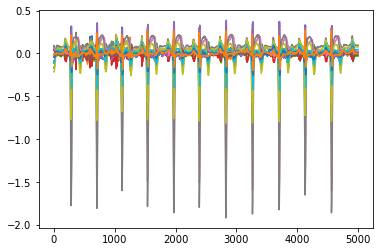

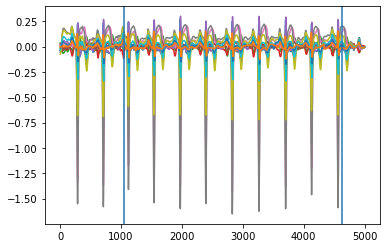

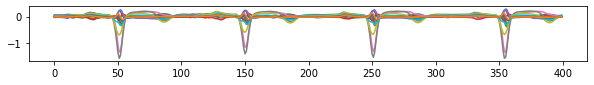

((5000, 12),
 52,
 0,
 500,
 array([164865005, 164951009,  39732003, 426783006], dtype=int32),
 (1, 400, 12))

In [257]:
(
    signal,
    cleaned_signal,
    age,
    sex,
    fs,
    dx,
    beats,
    valid_beats,
    beat_windows
) = get_signal(29247)#(14390)#(43098)

plt.plot(signal)
plt.show()
plt.plot(cleaned_signal)
# print(cleaned_signal.shape)
all_r_peaks_flat = np.concatenate(beats)[:, np.newaxis]
sig_range = np.linspace(0, all_r_peaks_flat.max(), len(cleaned_signal))[:, np.newaxis]
for sc in sig_range[valid_beats]:
    plt.axvline(x=sc)
plt.show()

# find outlier
# clf = LocalOutlierFactor(n_neighbors=len(beat_windows)//2)
# print(clf.fit_predict(beat_windows.reshape(len(beat_windows), -1)))
# print(clf.negative_outlier_factor_)
# outlier_idx = clf.negative_outlier_factor_.argmin()

fig, axs = plt.subplots(len(beat_windows), sharex=True, figsize=(10, len(beat_windows)))
for i in range(len(beat_windows)):
#     if i == outlier_idx:
#         axs[i].set_title("Local Outlier", pad=0, y=0.1, loc="left")
    try:
        axs[i].plot(beat_windows[i])
    except TypeError:
        axs.plot(beat_windows[i])
    # axs[i].plot(normalize(valid_windows[i].T).T)
plt.show()

signal.shape, age, sex, fs, dx, beat_windows.shape

## Debugging

(13, 400, 12)


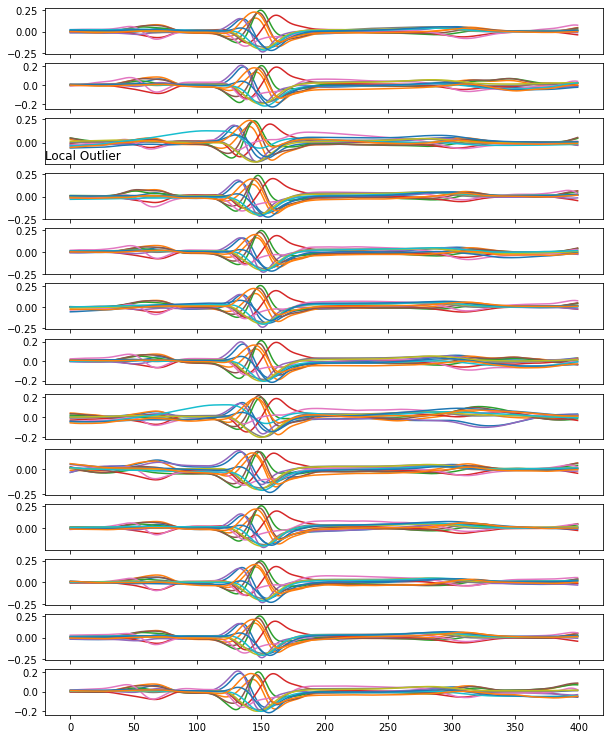

In [254]:
def _find_normalized_outlier(idx):
    windows = root[f"beats/window_size_{window_size}"][idx].reshape(
        root[f"beats/window_size_{window_size}_shape"][idx], order="C"
    )
    windows = np.nan_to_num(windows)
    return np.transpose(np.stack(list(map(normalize, np.transpose(windows, axes=(0, 2, 1))))), axes=(0, 2, 1))
beat_windows = _find_normalized_outlier(0)

print(beat_windows.shape)

fig, axs = plt.subplots(len(beat_windows), sharex=True, figsize=(10, len(beat_windows)))
for i in range(len(beat_windows)):
    if i == outlier_idx:
        axs[i].set_title("Local Outlier", pad=0, y=0.1, loc="left")
    axs[i].plot(beat_windows[i])
    # axs[i].plot(normalize(valid_windows[i].T).T)
plt.show()

In [235]:
import tqdm
for i in tqdm.trange(43099):
    assert all(np.isfinite(root["cleaned/p_signal"][i])), i

 35%|███▍      | 14930/43099 [05:33<10:28, 44.82it/s]


AssertionError: 14930

[[286, 709, 1120, 1541, 1973, 2392, 2828, 3265, 3703, 4129, 4563, 4913], [281, 705, 1117, 1537, 1968, 2388, 2823, 3260, 3698, 4125, 4559, 4901], [311, 737, 1147, 1532, 1962, 2383, 2817, 3288, 3730, 4119, 4554, 4893], [299, 721, 1134, 1554, 1985, 2405, 2840, 3278, 3716, 4142, 4576], [289, 713, 1124, 1545, 1976, 2396, 2831, 3269, 3707, 4133, 4567, 4914], [279, 703, 1116, 1535, 1966, 2386, 2821, 3258, 3696, 4123, 4557, 4898], [678, 4901], [1090, 4902], [1090, 1939, 4905], [1115, 4906], [282, 705, 1117, 1537, 1969, 2388, 2823, 3261, 3698, 4125, 4560, 4906], [282, 705, 1117, 1537, 1969, 2389, 2824, 3261, 3699, 4125, 4560, 4905]]


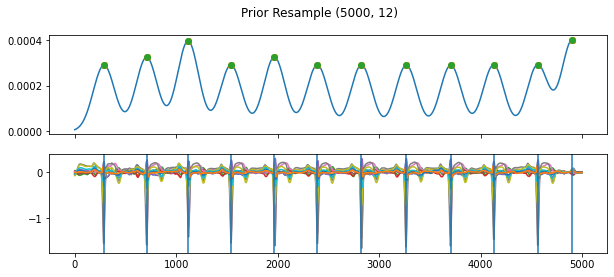

array([[[ 0.00815   ,  0.00033036, -0.00787741, ...,  0.06520027,
          0.02212862,  0.00850795],
        [ 0.00763842,  0.00118426, -0.0065097 , ...,  0.06497476,
          0.02251639,  0.00883621],
        [ 0.00719339,  0.00203476, -0.00521531, ...,  0.06490698,
          0.0229228 ,  0.0091188 ],
        ...,
        [-0.04892568, -0.0171076 ,  0.03184148, ...,  0.01092808,
          0.01405692, -0.00818158],
        [-0.05224437, -0.02132151,  0.03094568, ...,  0.01084315,
          0.0142297 , -0.0073049 ],
        [-0.05432406, -0.02431966,  0.03002837, ...,  0.01095879,
          0.01426954, -0.00645492]],

       [[-0.01297472, -0.02517961, -0.01216284, ...,  0.01691271,
          0.01763137,  0.01909059],
        [-0.01388322, -0.02766053, -0.01375509, ...,  0.01805503,
          0.01701721,  0.01947558],
        [-0.0139119 , -0.02939935, -0.01548531, ...,  0.0193402 ,
          0.01640309,  0.01958332],
        ...,
        [-0.02929133, -0.01034325,  0.01893956, ...,  

In [260]:
window_size = 400
def _generate_beats(idx):
    p_signal = root["cleaned/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    _, _, fs = root["raw/meta"][idx]
    
    def nk_ecg_peaks(cleaned_signal, sampling_rate=fs):
        try:
            _, ecg_r_peaks_dict = nk.ecg_peaks(
                cleaned_signal,
                sampling_rate=sampling_rate,
                method="neurokit",
                correct_artifacts=True,
            )
            r_peaks = ecg_r_peaks_dict["ECG_R_Peaks"].tolist()
            return r_peaks
        except Exception:
            return []

    all_r_peaks = list(map(nk_ecg_peaks, p_signal.T))

    print(all_r_peaks)
    # Join all of the R-peaks into a single vector
    all_r_peaks_flat = np.concatenate(all_r_peaks)[:, np.newaxis]
    sig_range = np.linspace(0, all_r_peaks_flat.max(), len(p_signal))[:, np.newaxis]

    # Find the peaks with bandwidth proportional to rough mean RR
    mean_beats_detected = np.mean([len(r_peaks) for r_peaks in all_r_peaks])
    rough_meanrr = np.mean(
        [np.diff(r_peaks).mean() for r_peaks in all_r_peaks if len(r_peaks) >= 2 and len(r_peaks) >= mean_beats_detected]
    )
    kde = KernelDensity(bandwidth=rough_meanrr / 4).fit(all_r_peaks_flat)
    log_dens = kde.score_samples(sig_range)
    dens = np.exp(log_dens)
    peaks, _ = ss.find_peaks(dens)

    # keep only the peaks that are greater than thereshold density
    threshold_peak_density = dens[peaks].mean() - (2 * dens[peaks].std())
    valid_peaks = peaks[dens[peaks] > threshold_peak_density]

    # DISPLAY/DEBUG
    fig, axs = plt.subplots(2, sharex=True, figsize=(10, 4))
    axs[0].plot(sig_range[:, 0], dens)
    axs[0].plot(sig_range[peaks], dens[peaks], "X")
    axs[0].plot(sig_range[valid_peaks], dens[valid_peaks], "o")
    axs[1].plot(p_signal)
    fig.suptitle(f"Prior Resample {p_signal.shape}")
    for vpeak in sig_range[valid_peaks]:
        plt.axvline(x=vpeak)
    plt.show()

#     r_peak_idxs[idx] = all_r_peaks
#     valid_r_peak_idxs[idx] = valid_peaks

    # resample the signal such that the mean distance between
    # valid R-peaks is equal to `window_size`
    scaling_indicies = sig_range[valid_peaks].squeeze()
    scaling_indicies = np.insert(scaling_indicies, 0, 0)
    scaling_indicies = np.append(scaling_indicies, len(p_signal))
    peak_diff_dist = np.diff(scaling_indicies)
    mean_peak_diff_dist = peak_diff_dist.mean()
    resamp_to_len = (len(p_signal) / mean_peak_diff_dist) * window_size
    resamp_to_len = int(np.ceil(resamp_to_len))
    p_signal = ss.resample(p_signal, resamp_to_len)

    # resample the peaks so we don't have to calculate again
    scaling_factor = window_size / mean_peak_diff_dist
    upscaled_peak_diff_dist = peak_diff_dist * scaling_factor
    scaled_indicies = np.r_[scaling_indicies[0], upscaled_peak_diff_dist].cumsum()
    scaled_indicies = scaled_indicies[1:-1]

    # slice up the windows and return the new matrices
    valid_windows = []
    sc_loffset = window_size * 0.35
    for sc in scaled_indicies:
        left_offset = int(np.floor(sc - sc_loffset))
        scaled_window = p_signal[left_offset : left_offset + window_size]
        if len(scaled_window) != window_size:
            # ignore windows that don't fit into window size
            continue
        valid_windows.append(scaled_window)

    valid_windows = np.stack(valid_windows)
#     beat_windows[idx] = valid_windows.flatten(order="C")
#     beat_window_shapes[idx] = valid_windows.shape

    return valid_windows

# _generate_beats(10) # good for figure
# _generate_beats(7)
_generate_beats(29247) # really strange outputs